# LSTM Implementation



    Response to the question : Suppose your model was deployed in production, and you have developed a new
    model. How would you test whether your new model is better? What metrics would you track.

Response :

To evaluate the effectiveness of the new message auto-completion model already in production, I will focus on three key evaluation axes:

1. Performance Metrics

I will measure the performance of both the old and new models using classical machine learning metrics, such as:

    -F1 Score: This will help assess the balance between precision and recall, giving insight into overall model effectiveness.

    -Precision and Recall: These metrics will indicate how many relevant suggestions were made and how many relevant suggestions were missed, respectively.

    -Accuracy: This will provide a general sense of how often the model’s predictions are correct.

I will conduct these evaluations using both new and old datasets to see how the new model performs in various contexts and against historical benchmarks.

2. Client Engagement

Understanding user engagement is really important for determining the model's impact on customer behavior. Henc,e I will monitor:

    -Selection Rate: Track how often clients are choosing the suggestions provided by the model. If the selection rate decreases significantly over time (e.g., for several months), it will signal the need for improvements.

    -A/B Testing: I will randomly assign users to either the old or new model to compare user interactions and see which model leads to better engagement or conversion rates.
    Feedback Surveys: I will collect direct feedback from users regarding their satisfaction with the suggestions provided by each model. This qualitative data can provide context for the quantitative metrics.

    -Session Duration: Analyzing how long users engage with the model during their sessions will help assess overall user experience. Longer session durations might indicate higher satisfaction with the suggestions.

3. Data Drift

Data drift can significantly affect model performance. I will monitor:

    - Input Data Distribution: I will regularly analyze the incoming data to check for shifts in distribution compared to the data used to train the old model. Significant changes may indicate that the new model needs retraining or adjustment.

    - Label Drift: If applicable, I will also keep track of changes in the underlying patterns of the data, such as the outcomes users expect. If the desired outcomes shift, it could impact the effectiveness of both models.

By systematically evaluating these three axes—performance metrics, client engagement, and data drift—I aim to provide a comprehensive understanding of how the new model performs compared to the old one and make informed decisions about any necessary adjustments.

# **Text Preprocessing**

In [63]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re
import sqlite3


In [64]:

cnx = sqlite3.connect('reddit.db')

df = pd.read_sql_query("SELECT * FROM comment", cnx)

In [65]:
data = df["body"].str.cat(sep=' ')
data[:50] # let's check the first 50 charachters

'my comment will be buried but what he heck \n i was'

# Clean Data

We start by loading a list of bad words from a file ("found online"), which helps us filter out inappropriate content. Our preprocessing steps include removing emojis and special characters to standardize the text, ensuring it is free from unnecessary noise. We eliminate sentences containing bad words to maintain the appropriateness of the data, and we convert the remaining text to lowercase for consistency.

Add badwords elimination

In [69]:
import pandas as pd

def load_bad_words(file_path):
    """
    Load bad words from a text file into a list.
    
    Args:
        file_path (str): Path to the text file containing bad words.
    
    Returns:
        list: A list of bad words.
    """
    with open(file_path, 'r', encoding='utf-8') as file:

        bad_words = [line.strip() for line in file if line.strip()]
    return bad_words

def remove_emojis_and_special_characters(text):
    """
    Remove emojis and special characters from the text.
    
    Args:
        text (str): The input text from which to remove emojis and special characters.
    
    Returns:
        str: The cleaned text.
    """

    import re
    return re.sub(r'[^\w\s]', '', text) 

def remove_sentence_bad_words(texts, bad_words):
    """
    Remove strings from the input list that contain bad words.
    
    Args:
        texts (list): A list of strings to check for bad words.
        bad_words (list): A list of bad words to filter out.
    
    Returns:
        tuple: A tuple containing the cleaned list and the count of eliminated rows.
    """

    pattern = r'\b(?:' + '|'.join(bad_words) + r')\b'
    
    # Filter out strings containing any bad words
    filtered_texts = [text for text in texts if not pd.Series(text).str.contains(pattern, case=False, na=False).any()]
    
    eliminated_count = len(texts) - len(filtered_texts)
    
    return filtered_texts, eliminated_count

def preprocess_pipeline(data, bad_words) -> 'list':
    """
    Preprocess the input text data by cleaning and tokenizing sentences.
    
    Args:
        data (str): The input text data to preprocess.
        bad_words (list): A list of bad words to filter out from the sentences.
    
    Returns:
        list: A list of cleaned and tokenized sentences.
    """
    sentences = data.split('\n')
    
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    
    sentences = [s.strip() for s in sentences]
    
    sentences = [s for s in sentences if len(s) > 0]
    
    cleaned_sentences, _ = remove_sentence_bad_words(sentences, bad_words)
    
    tokenized = [sentence.lower() for sentence in cleaned_sentences]
    
    return tokenized
# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)

In [70]:
tokenized_sentences[:10]

['my comment will be buried but what he heck',
 'i was probably 8 or 9 at the time trampolines were the best shit in the world one day doing flips i lost my sense of reality or something and went head first strait into the ground with my eyes squeezing tight knowing my fate is at handi open my eyes and my head is inches above the ground and im dangling there my legs caught the space between the springs luckily and i knew i had nothing to do with it i wasnt trying to save myself but i believe god was watchin out for me thanks jesus i love you reddit dont downvote me lol',
 'tldr flying spaghetti monster lassowed me inches from certain death',
 'in the seventh grade i played lacrosse in my citys league at practice one day we were doing one on ones and it came to be my turn to be the defender i took my place between the attacker and the goal and squared up as he ran toward me he began to dodge to my right and so i started turning to follow my right leg and rest of my body kept with the tu

THe sentences are really long and people are not really using "." so I will seperate the text based on fixed size sentences to increase my learning samples.

In [71]:
def split_sentences_into_chunks(sentences, chunk_size=10):
    """
    Splits each sentence in the input list into smaller chunks of a fixed size.

    Args:
        sentences (list of str): A list containing sentences as strings.
        chunk_size (int): The fixed length of the word chunks (default is 7).

    Returns:
        list: A list of word chunks as strings, where each chunk contains chunk_size words.
    """
    chunks = []
    for sentence in sentences:
        # Tokenize the sentence into words
        words = sentence.split()  # Splits the sentence into words
        # Iterate over the words in steps of chunk_size
        for i in range(0, len(words), chunk_size):
            chunk = words[i:i + chunk_size]  # Get the chunk of size chunk_size
            if len(chunk) == chunk_size:  # Only append full chunks
                chunks.append(' '.join(chunk))  # Join the chunk into a string and append it to the list
    return chunks
tokenized_sentences = split_sentences_into_chunks(tokenized_sentences)


In [72]:
tokenized_sentences[:10]

['i was probably 8 or 9 at the time trampolines',
 'were the best shit in the world one day doing',
 'flips i lost my sense of reality or something and',
 'went head first strait into the ground with my eyes',
 'squeezing tight knowing my fate is at handi open my',
 'eyes and my head is inches above the ground and',
 'im dangling there my legs caught the space between the',
 'springs luckily and i knew i had nothing to do',
 'with it i wasnt trying to save myself but i',
 'believe god was watchin out for me thanks jesus i']


We use out-of-vocabulary (OOV) tokens to help models handle unseen or rare words, improving robustness and generalization. They prevent errors when unknown words appear, allowing the model to process them effectively, which is essential in NLP tasks where the vocabulary can't cover all possible words.

The bad words used during promt will be treated as OOV

In [73]:
# Tokenize words
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1


Saving the tokenizer is important because it keeps track of the mapping between words and their corresponding indices. During inference or deployment, we need the exact same tokenizer used during training to ensure consistency when converting text into sequences of numbers.

In [74]:
# with open('tokenizer.p', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
import io
import json
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

We create sequences of tokens (words represented as numbers) that can be used to train a model. These sequences are n-grams, where each sequence is a progressively longer fragment of the original sentence. 

The generated sequences will be used for tasks such as language modeling or next-word prediction.

In [75]:

input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)



We proceed with Padding the previous sequences to ensure uniform input length, which allow us to process variable-length sequences using models like LSTMs.


This technique allows us to handle various input text lengths without losing important context, helping with efficient batch processing and avoiding errors in training or inference.

In [76]:
# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

We splits input_sequences into X (input data) by removing the last word from each sequence, and labels (target data) as the last word of each sequence. 

We then converts labels into a one-hot encoded format (ys), representing the target word as a vector of length total_words for use in training. In this way, the model learns to predict the next word in a sentence based on the previous words, which is the core task in sentence autocompletion. The task of predicting several words, is a multi-step prediction step. Indeed, the model generates one word at a time based on the input sequence, then uses each predicted word as part of the input to predict the next word in a sequential manner until the desired number of words is completed. 

we could formulate the problem as a Sequence Prediction (Seq2Seq task) task where the model takes an input sequence and predicts an entire fixed-length output sequence at once. 

In [77]:
# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]

In [78]:
X

array([[    0,     0,     0, ...,     0,     0,     6],
       [    0,     0,     0, ...,     0,     6,    13],
       [    0,     0,     0, ...,     6,    13,   174],
       ...,
       [    0,     0,   279, ...,    51,    10,     5],
       [    0,   279,     3, ...,    10,     5, 13863],
       [  279,     3,  1136, ...,     5, 13863,   246]], dtype=int32)

In [79]:
# Split data into training, validation, and test sets

X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [80]:
X_train_temp.shape

(94500, 9)

I've been trying to improve the model's performance, but it continues to overfit the data. The LSTM keeps generating almost identical words with minor changes, which I notice during testing. Additionally, the validation accuracy gets stuck at a single value for several epochs.

Given the time constraints, I'm couldn't switch to a transformer-based solution or performing zero-shot prompting GPT2 or something similar. In this situation, I believe we need a model with greater capacity to understand context, something that LSTM struggles with.

# Train LSTM Model

In [86]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from keras.optimizers import Adam
from keras.regularizers import l2


# Define the model
model = Sequential()

model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.4))

model.add(LSTM(128, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(total_words, activation='softmax'))


learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(X_train_temp, y_train_temp, epochs=50, validation_data=(X_val, y_val), verbose=1)



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 9, 100)            1386400   
                                                                 
 bidirectional_9 (Bidirectio  (None, 9, 256)           234496    
 nal)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 9, 256)            0         
                                                                 
 lstm_21 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 13864)             1788456   
                                                     

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2954/2954 [==============================] - 18s 5ms/step - loss: 7.0317 - accuracy: 0.0449 - val_loss: 6.8559 - val_accuracy: 0.0476
Epoch 2/50
2954/2954 [==============================] - 15s 5ms/step - loss: 6.6928 - accuracy: 0.0518 - val_loss: 6.8043 - val_accuracy: 0.0537
Epoch 3/50
2954/2954 [==============================] - 15s 5ms/step - loss: 6.5129 - accuracy: 0.0646 - val_loss: 6.7633 - val_accuracy: 0.0681
Epoch 4/50
2954/2954 [==============================] - 14s 5ms/step - loss: 6.3666 - accuracy: 0.0799 - val_loss: 6.7426 - val_accuracy: 0.0843
Epoch 5/50
2954/2954 [==============================] - 15s 5ms/step - loss: 6.2408 - ac

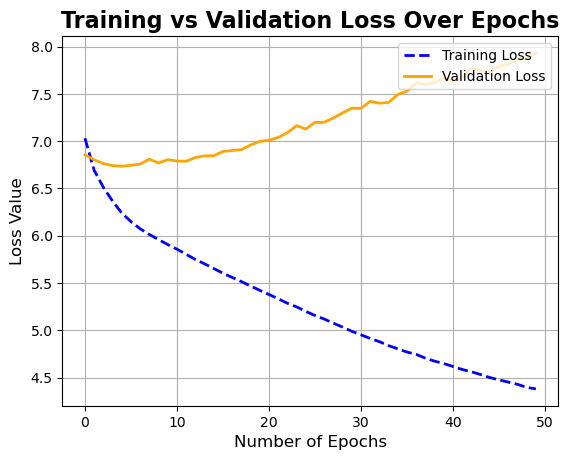

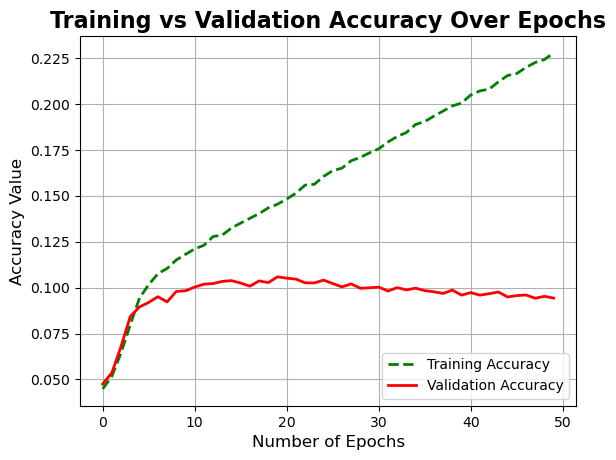

In [87]:

import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='--', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='-', linewidth=2)
plt.title('Training vs Validation Loss Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Number of Epochs', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)  
plt.show()


plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='--', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='-', linewidth=2)
plt.title('Training vs Validation Accuracy Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Number of Epochs', fontsize=12)
plt.ylabel('Accuracy Value', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True) 
plt.show()


# Save Models (Weights and biases)

In [88]:
# Save model architecture as JSON file
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Load model architecture from JSON file
from tensorflow.keras.models import model_from_json

with open("lstm_model.json", "r") as json_file:
    loaded_model_json = json_file.read()

# Create model from loaded architecture
loaded_model = model_from_json(loaded_model_json)

print("Model architecture loaded successfully from JSON file.")

Model architecture loaded successfully from JSON file.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Inferences

In [ ]:
def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words


In [ ]:
from IPython.display import HTML

def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

def predict_and_display_top_five_words(seed_text, model, tokenizer):
    top_five_words = predict_top_five_words(model, tokenizer, seed_text)
    print(top_five_words)
    return top_five_words




In [ ]:
# Test 3:
seed_text = "How are you"
predict_and_display_top_five_words(seed_text, loaded_model, tokenizer)

['his', 'un', 'producing', 'light', 'whats']
